In [1]:
import numpy as np
from icecream import ic
from tqdm import tqdm
import cProfile 
import time
import warnings
import math

In [2]:
# Warning settings
np.seterr(all="ignore") #ignore np warnings, the output will be nan or inf and will be handled correctly in the code. (using np.errstate slows down the code)
# warnings.filterwarnings("ignore", category=RuntimeWarning)

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Load a problem

In [110]:
# Configuration
TRAIN_TEST_RATIO=0.8
PROBLEM_NUMBER=1

# Load problem data with context manager protocol
with np.load(f'data/problem_{PROBLEM_NUMBER}.npz') as problem:
    x_1 = problem['x']
    y_1 = problem['y']

# Shuffle the data
permutation = np.random.permutation(len(y_1))
x_1 = x_1[:, permutation]
y_1 = y_1[permutation]

# Determine train test split sizes
problem_len=len(y_1)
train_size=int(TRAIN_TEST_RATIO*problem_len)

# Split data
x_train=x_1[:, :train_size]
y_train=y_1[:train_size]

x_test=x_1[:, train_size:]
y_test=y_1[train_size:]

# To view the npz file, run python -m npzviewer 
# Print dataset information
print(f"Problem number: {PROBLEM_NUMBER}, variables: {x_1.shape[0]}, train size: {train_size}, test size: {problem_len-train_size}")

Problem number: 1, variables: 1, train size: 400, test size: 100


### Numpy functions definition

In [98]:
unary_ops = [
    np.negative,
    np.abs,
    np.sqrt,
    np.exp,
    np.log,
    np.sin,
    np.cos,
    np.tan,
    # np.arcsin,
    # np.arccos,
    # np.arctan,
    # np.ceil,
    # np.floor
]

binary_ops = [
    np.add,
    np.subtract,
    np.multiply,
    np.divide,
    np.power,
    # np.maximum,
    # np.minimum,
    # np.mod
]

### Symbolic regression class

In [111]:
from tree import Tree

class SymbolicRegression:
    def __init__(self, population_size, max_generations, mutation_rate, elitism_size, grow_full_ratio):
        self.population_size = population_size
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism_size = elitism_size
        self.grow_full_ratio = grow_full_ratio

        self.unary_ops = unary_ops
        self.binary_ops = binary_ops
        self.best_fitness_history = []
        self.random_parents_generations = self.max_generations * 0.005   # random parents selection generations

        self.population = np.array([
            Tree("grow") if i < int(population_size * self.grow_full_ratio) else Tree("full")
            for i in range(population_size)
        ])

    # Parents selection methods
    def select_parents_fitness_age(self, n_elems=2):
        """
        Evolves a population considering how long the genotype has been in the population and fitness.
        Reference: Age-fitness pareto optimization https://dl.acm.org/doi/10.1145/1830483.1830584
        """
        return sorted(self.population, key=lambda tree: (-tree.fitness, -tree.age))[:n_elems]

    def select_parents_fitness_proportional(self, n_elems=2, epsilon=1e-10):
        """
        Individuals with lower fitness have an higher probability to be selected.
        Premature convergence if few individuals have significantly better fitness than others.
        """
        fitnesses = [tree.fitness for tree in self.population]
        inverted_fitnesses = [1 / (fitness + epsilon) for fitness in fitnesses]  # avoid division by zero
        probabilities = inverted_fitnesses / sum(inverted_fitnesses)
        parent1, parent2 = np.random.choice(self.population, size=n_elems, p=probabilities, replace=False)
        return parent1, parent2
    
    def select_parents_lexicase(self):  # TODO: implement this
        pass

    def select_parents_rank_based(self, n_elems=2):
        """
        Rank-based selection method.
        Assigns probabilities based on inversed ranks instead of absolute fitness values.
        """
        fitnesses = np.array([tree.fitness for tree in self.population])
        ranks = np.argsort(fitnesses)
        inversed_ranks = len(fitnesses) - ranks
        probabilities = inversed_ranks / np.sum(inversed_ranks)
        return np.random.choice(self.population, n_elems, p=probabilities,replace=False)
    
    def select_parents_tournament(self):
        tournament_size = 7
        tournament = list(np.random.choice(self.population, tournament_size,replace=False))
        tournament.sort(key=lambda x: x.fitness)
        return tournament[0], tournament[1]
    
    def select_parents(self):
        # if np.random.rand() < 0:
            # return self.select_parents_tournament()
        # else:
        return self.select_parents_fitness_proportional()

    # Mutation
    def mutate(self, tree):
        if np.random.rand() < self.mutation_rate:
            if np.random.rand() < 0.5:
                tree.mutate_subtree()
            else:
                tree.mutate_single_node()

    def offspring_generation(self, current_generation):
        new_population = np.array([])

        # Elitism   
        elite_individuals = self.population[:self.elitism_size]
        new_population = elite_individuals

        # Main loop
        while len(new_population) < self.population_size: # //2:
            # encourage exploration in initial generations
            if current_generation < self.random_parents_generations:
                parent1, parent2 = np.random.choice(self.population, size=2, replace=False)
            else:
                parent1, parent2 = self.select_parents()
            # generate offsprings
            offsprings=np.array([])
            if(np.random.rand() < 0.1):
                parent_clone=parent1.copy_tree()
                self.mutate(parent_clone)
                Tree.collapse_branch(parent_clone.root)
                parent_clone.compute_fitness()
                # if(parent_clone not in new_population):
                offsprings = np.append(offsprings, [parent_clone])

            else:    
                offspring1,offspring2=Tree.crossover(parent1, parent2)
                if(offspring1 is not None or offspring2 is not None):
                    Tree.collapse_branch(offspring1.root)
                    Tree.collapse_branch(offspring2.root)
                
                    # self.mutate(offspring1)
                    # self.mutate(offspring2)

                    #Trying stuff
                    # offspring1.compute_fitness()
                    # offspring2.compute_fitness()
                    # tmp_fitnesses=[tree.fitness for tree in new_population]
                    # if offspring1.fitness not in tmp_fitnesses:
                    #     offsprings.append(offspring1)
                    # if offspring2.fitness not in tmp_fitnesses:
                    #     offsprings.append(offspring2)
                    
                    offspring1.compute_fitness()
                    offspring2.compute_fitness()
                    #if osspring1 is not alredy in population, already defined the eq as the fitness comparison
                    # if offspring1 not in new_population:
                    #     offsprings = np.append(offsprings, [offspring1])
                    # if offspring2 not in new_population:
                    #     offsprings = np.append(offsprings, [offspring2])
                    

                    offsprings = np.append(offsprings, [offspring1, offspring2])

            new_population=np.concatenate((new_population,offsprings))
                
        return new_population


    def evolve(self):
        best_tree = None
        best_fitness = np.inf
        take_over = False
        # self.population.sort(key=lambda x: x.fitness) 
        #numpy sort of population over fitness
        self.population.sort()
        # print(f"Initial best fitness: {self.population[0].fitness}")
        # print(f"Initial best fitness: {self.population[1].fitness}")
        # print(f"Initial best fitness: {self.population[2].fitness}")
        # print(f"Initial worst fitness: {self.population[-1].fitness}")



        for generation in tqdm(range(self.max_generations)):
            
            if take_over:
                #trasform the population in set and then back to list to remove duplicates
                self.population=np.unique(self.population)
                #sort the population based on fitness
                self.population.sort()
                self.population = self.population[:int(self.population_size*0.1)]
                new_trees = np.array([Tree("grow") for _ in range(int(self.population_size*0.3))]+[Tree("grow") for _ in range(int(self.population_size*0.3))])
                self.population=np.concatenate((self.population,new_trees))
            
            
            new_population=self.offspring_generation(generation)

            # for tree in new_population:
            #     tree.compute_fitness()
                
            self.population=np.concatenate((self.population,new_population))
            
            generation_fitnesses = [tree.fitness for tree in self.population]
            generation_best_fitness = min(generation_fitnesses)

            if generation_best_fitness < best_fitness:
                best_fitness = generation_best_fitness
                best_tree = self.population[np.argmin(generation_fitnesses)]
                self.best_fitness_history.append(best_fitness)
            #trim the population to the best population_size
            self.population.sort()
            self.population = self.population[:self.population_size]
            # print(f"Generation {generation + 1}, Best Fitness: {best_fitness}")
            

            n_best = [elem for elem in self.population if elem.fitness == self.population[0].fitness]
            take_over = False
            if len(n_best) > 0.9 * self.population_size:
                    take_over = True
                    # print(f"Takeover at {generation} gen")     
            if(generation%50==0):
                print(f"Generation {generation + 1}, Best Fitness: {best_fitness}, Best Formula: {best_tree.to_np_formula()}")
            if best_fitness <= 1e-33:
                break   
        return best_tree, best_fitness


In [112]:
#Problem definition
POPULATION_SIZE = 1000
MAX_GENERATIONS = 1000
MUTATION_RATE = 0.1
ELITISM_SIZE = 2
GROW_FULL_RATIO = 1
#TREE_DEPTH = math.ceil(math.log(x_train.shape[0],2))+1 #FIXME: temporary solution,IDK if it's good. (it's the depth to contain all the variables+1)
#print("Tree depth:",TREE_DEPTH)
TREE_DEPTH = 4
VAR_NUM = x_train.shape[0]
CONST_RANGE=10 # Constats will be in the range [-CONST_RANGE, CONST_RANGE]


Tree.set_params(unary_ops, binary_ops, VAR_NUM, 10,TREE_DEPTH, x_train, y_train, x_test, y_test)
regressor = SymbolicRegression(
    POPULATION_SIZE,
    MAX_GENERATIONS,
    MUTATION_RATE,
    ELITISM_SIZE,
    GROW_FULL_RATIO
    #(x_train, y_train)   # per lexicase
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generation 1, Best Fitness: 6.98149604840373e-34, Best Formula: np.sin(x[0])
Best Formula:

np.sin(x[0])
Train Fitness: 6.98149604840373e-34
Test Fitness: 7.703719777548943e-34
Train-Test Discrepancy: -7.222237291452134e-35
All Fitness: 7.125940794232773e-34
Best Fitness History: [np.float64(6.98149604840373e-34)], changed 1 times
Best Tree:


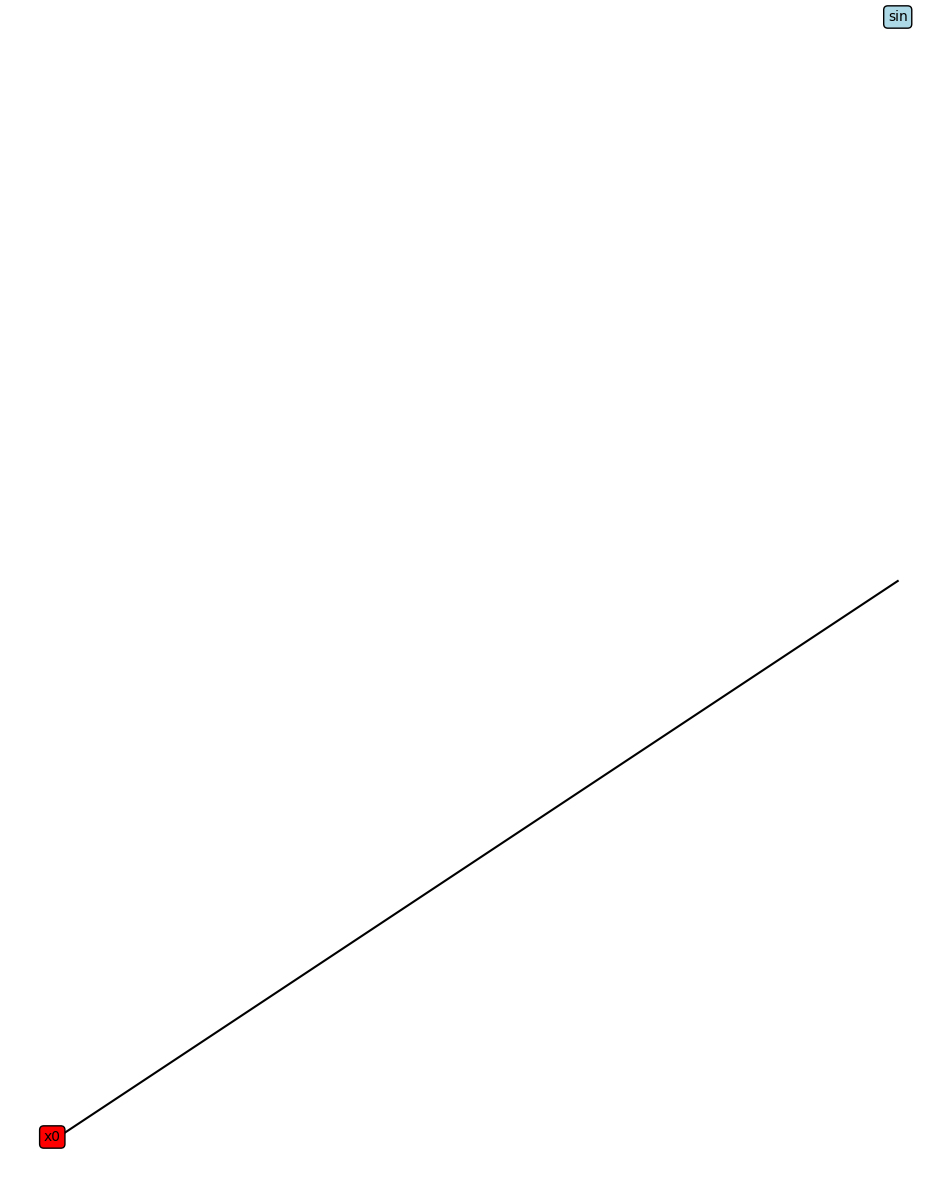

In [113]:
#UNCOMMENT TO PROFILE THE CODE (and comment the rest of the code)
# cProfile.run("regressor.evolve()",sort="tottime") #for profiling so we can see the time taken by each function
#the output will include the following columns:
#tottime: Total time spent in the function (excluding time spent in other functions it calls).
#cumtime: Cumulative time spent in the function (including time spent in sub-functions).


# Execute the algorithm
best_tree, best_fitness = regressor.evolve()

# Print the formula
print("Best Formula:\n")
print(best_tree.to_np_formula())

# Print the fitness
print(f"Train Fitness: {best_fitness}")
best_tree.compute_fitness(test="test")
print(f"Test Fitness: {best_tree.fitness}")
print(f"Train-Test Discrepancy: {best_fitness-best_tree.fitness}")
best_tree.compute_fitness(test="all")
print(f"All Fitness: {best_tree.fitness}")

# Print the best tree
print(f"Best Fitness History: {regressor.best_fitness_history}, changed {len(regressor.best_fitness_history)} times")
print("Best Tree:")
best_tree.add_drawing()

Collapsed formula: np.sin(x[0])
Best Tree after collapsing:


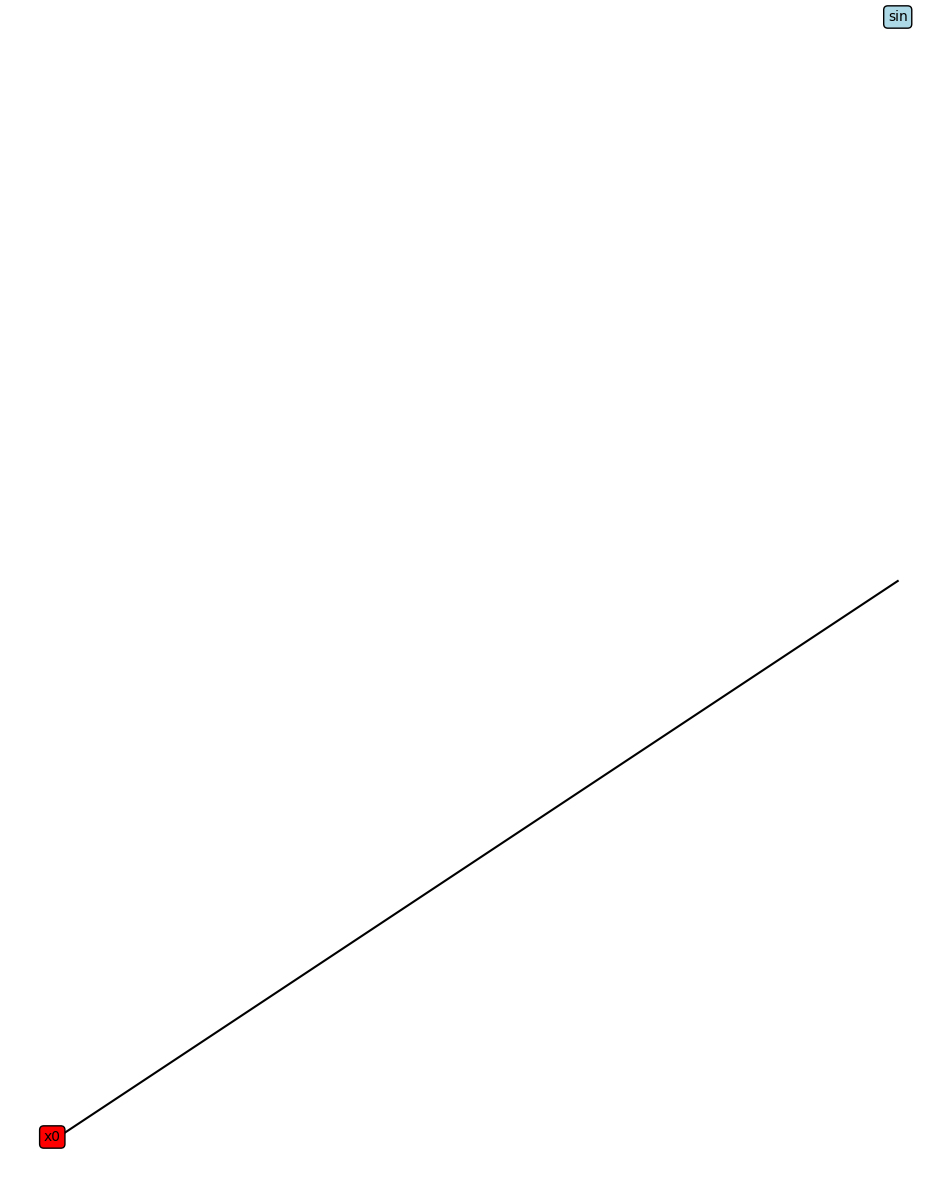

In [135]:
#Collapse branches that can be simplified
Tree.collapse_branch(best_tree.root,0,force_collapse=True)
print(f"Collapsed formula: {best_tree.to_np_formula()}")
print("Best Tree after collapsing:")
best_tree.add_drawing()


In [136]:

# def test_formula(x):
#     pass



# x_tot=np.concatenate((x_train,x_test),axis=1)
# y_tot=np.concatenate((y_train,y_test))
# squared_errors = 0
# for i in range(1):
#     y_pred = test_formula(x_tot[:, i])
                 
#     squared_errors += np.square(y_tot[i] - y_pred) 

# print( squared_errors / x_tot.shape[1])
   

# def testing(tree):
#    tree.compute_fitness()
#    tree.compute_fitness2()

# cProfile.run("testing(best_tree)",sort="tottime") #for profiling so we can see the time taken by each function


# best_tree.compute_fitness()
# print(best_tree.fitness)
# best_tree.compute_fitness2()
# print(best_tree.fitness)
